<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/aspinenetv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pycocotools.coco import COCO
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
print(keras.__version__)
print(tf.__version__)
import pandas as pd
import os
from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.utils import get_source_inputs
from keras.losses import categorical_crossentropy

from keras.models import Model
from keras import initializers, regularizers

from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils import generic_utils
from tensorflow.keras.layers import Layer,InputSpec

2.15.0
2.15.0


In [3]:
train_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_train"
val_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_val"
val_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Validation.json"
train_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Train.json"

In [4]:
class DataframeMaker():

  def __init__(self,img_path, annotations_file, img_height=None, img_width=None):
      self.img_path = img_path
      self.coco = COCO(annotations_file)
      self.imgIds = self.coco.getImgIds()
      self.dataframe = None
      self.img_height = img_height
      self.img_width = img_width

      if self.img_width and self.img_height:
          self.resize_dataset()
          print ("image size has been set to %d x %d" % (self.img_height, self.img_width))
      else:
          print ("image keeps as original size")

  def __coco_build__(self):
      """
      read annotation and return dict
      :return:
      """

      all_imgs = {}

      for id in self.imgIds:

        # load a image
        img = self.coco.loadImgs(id)[0]
        filename = img['file_name']

        ann=self.coco.loadAnns(self.coco.getAnnIds(imgIds=img['id']))

        filepath = os.path.join(self.img_path,filename)

        bb = ann[0]['bbox']

        if filename not in all_imgs:
          if self.img_width and self.img_height:
            (rows,cols) = self.img_width, self.img_height
          else:
            (rows,cols) = cv2.imread(filepath).shape[:2]
          all_imgs[filename] = {}
          all_imgs[filename]['filepath'] = filepath
          all_imgs[filename]['width'] = cols
          all_imgs[filename]['height'] = rows
          all_imgs[filename]['bboxes'] = []
          # if np.random.randint(0,6) > 0:
          # 	all_imgs[filename]['imageset'] = 'trainval'
          # else:
          # 	all_imgs[filename]['imageset'] = 'test'

          all_imgs[filename]['bboxes'].append({'class': 'pelvis', 'x1': int(bb[0]), 'x2': int(bb[0]+bb[2]), 'y1': int(bb[1]), 'y2': int(bb[1]+bb[3])})

      return all_imgs

  def get_data(self):
      all_data = []
      classes_count = {'pelvis': 0}

      all_imgs = self.__coco_build__()
      for key in all_imgs:
        all_data.append(all_imgs[key])
        classes_count['pelvis'] += 1

      return all_data, classes_count, {'pelvis': 0}

        # kps_row = []
        # for kp in keypoints_original:
        #     for el in kp:
        #         kps_row.extend(el[0:2])
        # kps_row.append(imgPath)

        # kps_metrix.append(keypoints_original)

      # df = pd.DataFrame(kps_metrix)

      # self.dataframe = df


In [5]:
val_df = DataframeMaker(val_img_dir,val_annotations_file)
train_df = DataframeMaker(train_img_dir,train_annotations_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
image keeps as original size
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
image keeps as original size


In [6]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [128, 256, 512]

		# Anchor box ratios
		# self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
		self.anchor_box_ratios = [[1,1], [2,1], [1,2]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 640

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = True

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

In [7]:
def get_data(input_path):
  """Parse the data from annotation file

  Args:
    input_path: annotation file path

  Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num}
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
  found_bg = False
  all_imgs = {}

  classes_count = {}

  class_mapping = {}

  visualise = True

  i = 1

  with open(input_path,'r') as f:
    print('Parsing annotation files')

    for line in f:

      # Print process
      sys.stdout.write('\r'+'idx=' + str(i))
      i += 1
      line_split = line.strip().split(',')
			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2
      (filename,x1,y1,x2,y2,class_name) = line_split

      if class_name not in classes_count:
        classes_count[class_name] = 1
      else:
        classes_count[class_name] += 1

      if class_name not in class_mapping:
        if class_name == 'bg' and found_bg == False:
          print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
          found_bg = True
        class_mapping[class_name] = len(class_mapping)

      if filename not in all_imgs:
        all_imgs[filename] = {}

        img = cv2.imread(filename)
        (rows,cols) = img.shape[:2]
        all_imgs[filename]['filepath'] = filename
        all_imgs[filename]['width'] = cols
        all_imgs[filename]['height'] = rows
        all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

      all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


    all_data = []
    for key in all_imgs:
      all_data.append(all_imgs[key])

		# make sure the bg class is last in the list
    if found_bg:
      if class_mapping['bg'] != len(class_mapping) - 1:
        key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
        val_to_switch = class_mapping['bg']
        class_mapping['bg'] = len(class_mapping) - 1
        class_mapping[key_to_switch] = val_to_switch

    return all_data, classes_count, class_mapping

ROI Head

In [8]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)


        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output


    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Build a VGG16 Backbone

In [9]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)
    if not K.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

RPN Head

In [10]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

IOU Calucation

In [11]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer

    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

In [12]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

Calculate the rpn for all anchors

In [13]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors

	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride)
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3

	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))

	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]

			for ix in range(output_width):
				# x-coordinates of the current anchor box
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2

				# ignore boxes that go across image boundaries
				if x1_anc < 0 or x2_anc > resized_width:
					continue

				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):

						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

In [14]:
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

In [15]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)

	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

In [16]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [17]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X

def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [18]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors)
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride

			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

In [19]:
base_path = '/content/'
# train_path =  '/content/dataset/cnn-annotation-txt/test_annotation.txt' # Training data (annotation file)

num_rois = 200 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training.
vertical_flips = True   # Augment with vertical flips in training.
rot_90 = True           # Augment with 90 degree rotations in training.

output_weight_path = os.path.join(base_path, 'model_frcnn_vgg.hdf5')

record_path = os.path.join(base_path,'record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)
print(record_path)

base_weight_path = os.path.join('/content/drive/MyDrive/Dataset/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

config_output_filename = os.path.join('model_vgg_config.pickle')

/content/record.csv


Initialize Configuration

In [20]:
# Create the config
C = Config()

# C.use_horizontal_flips = horizontal_flips
# C.use_vertical_flips = vertical_flips
# C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path


Loading Data and annotation

In [21]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
train_imgs, classes_count, class_mapping = train_df.get_data()
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )


Spend 2.32 mins to load the data


In [22]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'usask_1': 5807,'arvalis_1': 45716,'inrae_1': 3701,'ethz_1': 51489,'arvalis_3': 16665,'rres_1': 9635,'bg':0}
#    class_mapping: {'usask_1': 0,'arvalis_1': 1,'inrae_1': 2,'ethz_1': 3,'arvalis_3': 4,'rres_1': 5,'bg': 6}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


Training images per class:
{'bg': 0, 'pelvis': 188}
Num classes (including bg) = 2
{'pelvis': 0, 'bg': 1}
Config has been written to model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [23]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 188


In [24]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

In [25]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=2112 width=1184
Resized image:  height=1141 width=640 C.im_size=640
Feature map size: height=71 width=40 C.rpn_stride=16
(1, 1141, 640, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 71, 40, 18)
Shape of y_rpn_regr (1, 71, 40, 72)
{'filepath': '/content/drive/MyDrive/Dataset/aspine20230930/image_train/img-00129-00001.jpg', 'width': 1184, 'height': 2112, 'bboxes': [{'class': 'pelvis', 'x1': 197, 'x2': 997, 'y1': 1414, 'y2': 1954}]}
Number of positive anchors for this image: 26
(array([ 6,  7, 14, 16, 17, 24, 25, 33, 34, 34, 36, 37, 39, 43, 43, 43, 44,
       45, 45, 46, 47, 51, 52, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57,
       57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 58, 58, 60, 66]), array([17, 13, 24, 34, 30,  9, 17, 33, 21, 21, 31, 21, 30,  4,  9, 24, 18,
       18, 31, 35, 12, 23, 15, 17, 17, 18, 18, 19, 1

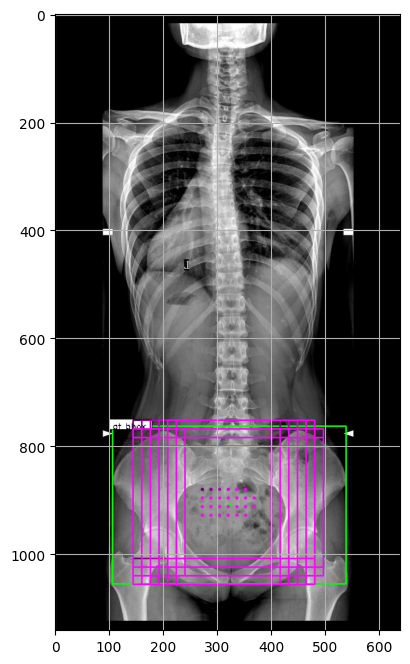

In [26]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#         cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()

In [27]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

In [28]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again),
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')

    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)

    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

Continue training based on previous trained model
Loading weights from /content/model_frcnn_vgg.hdf5
Already train 1K batches


In [29]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [30]:
# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 100
num_epochs = 20   #Just of sharing the karnel running with 2 epoch , you try with min 20 epochs
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

print(len(record_df))

1


In [31]:
start_time = time.time()
for epoch_num in range(num_epochs):

    progbar = generic_utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))

    r_epochs += 1

    while True:
        try:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
#                 print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)

            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue

            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()

                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time)/60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3),
                           'class_acc':round(class_acc, 3),
                           'loss_rpn_cls':round(loss_rpn_cls, 3),
                           'loss_rpn_regr':round(loss_rpn_regr, 3),
                           'loss_class_cls':round(loss_class_cls, 3),
                           'loss_class_regr':round(loss_class_regr, 3),
                           'curr_loss':round(curr_loss, 3),
                           'elapsed_time':round(elapsed_time, 3),
                           'mAP': 0}
                # record_df = record_df.append(new_row, ignore_index=True) depreciate
                record_df = pd.concat([record_df, pd.DataFrame([new_row])], ignore_index=True)

                record_df.to_csv(record_path, index=0)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue

print('Training complete, exiting.')

Epoch 2/21
100/100 [==============================] - 138s 1s/step - rpn_cls: 0.5871 - rpn_regr: 0.0522 - final_cls: 0.2994 - final_regr: 1.3601
Mean number of bounding boxes from RPN overlapping ground truth boxes: 12.87
Classifier accuracy for bounding boxes from RPN: 0.9312000042200088
Loss RPN classifier: 0.7201511637049862
Loss RPN regression: 0.046173736187629405
Loss Detector classifier: 0.2916899827704765
Loss Detector regression: 0.6199191461503506
Total loss: 1.6779340288134428
Elapsed time: 137.90249180793762
Total loss decreased from 33.257 to 1.6779340288134428, saving weights
Epoch 3/21
100/100 [==============================] - 96s 960ms/step - rpn_cls: 0.5665 - rpn_regr: 0.0442 - final_cls: 0.2496 - final_regr: 0.3431
Mean number of bounding boxes from RPN overlapping ground truth boxes: 12.33
Classifier accuracy for bounding boxes from RPN: 0.9370000028610229
Loss RPN classifier: 0.5145718182128425
Loss RPN regression: 0.04546599829103798
Loss Detector classifier: 0.22

In [32]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape

	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

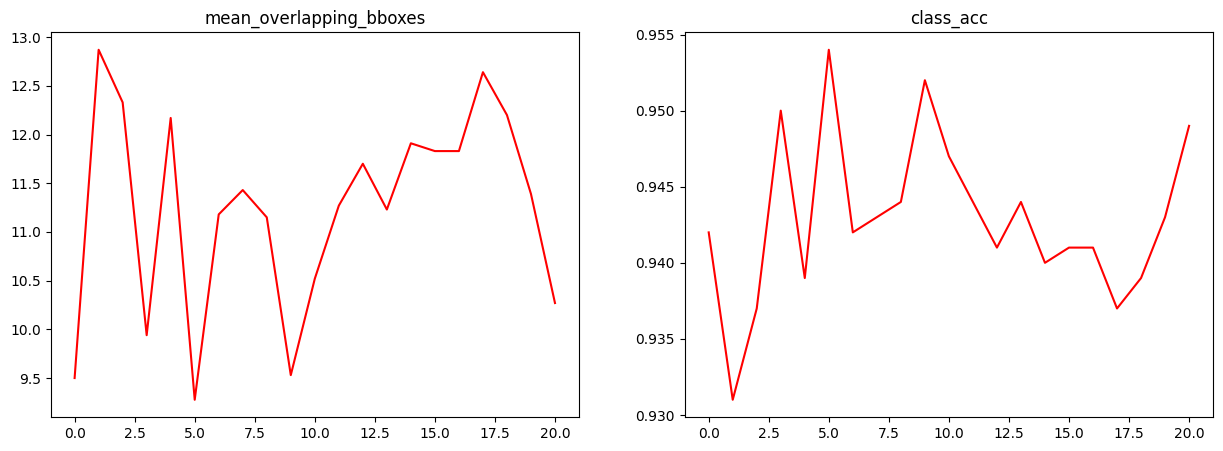

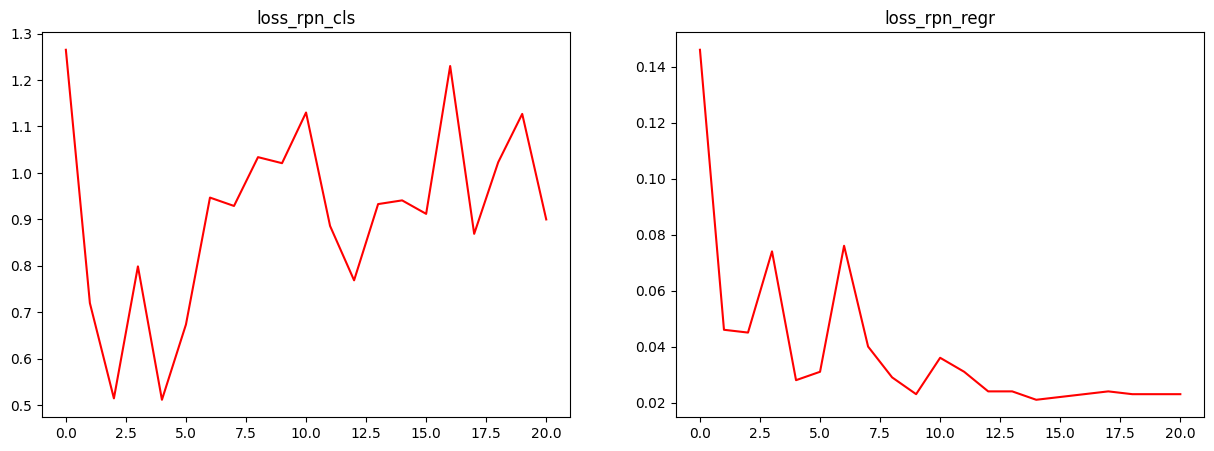

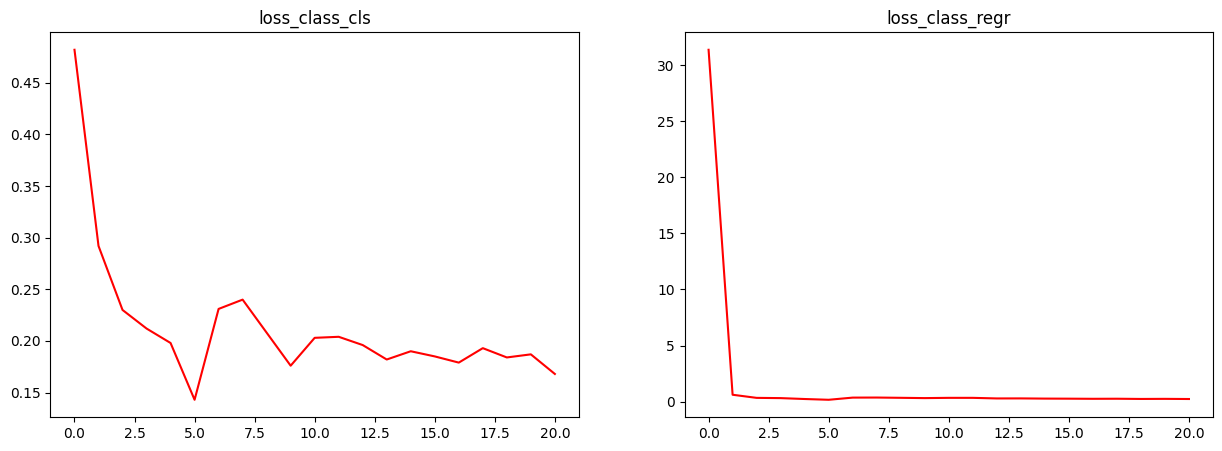

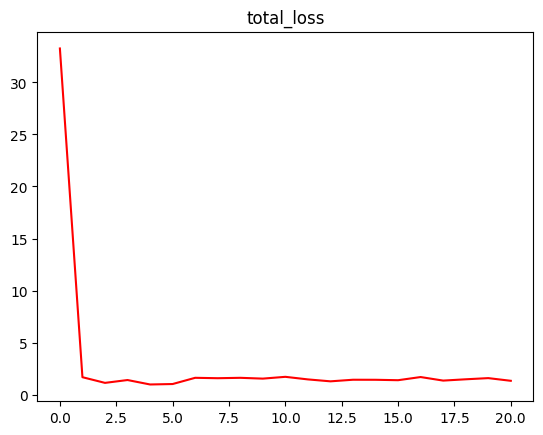

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()

In [76]:
from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.applications.mobilenet import preprocess_input

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


# define detections
all_boxes = [[[] for _ in range(len(os.listdir(val_img_dir)))] for _ in range(2)]

empty_array = np.transpose(np.array([[],[],[],[],[]]), (1,0))

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

num_features = 512
input_shape_features = (None, None, num_features)
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping))

model_rpn = Model(img_input, rpn)
#model_classifier_only = Model([feature_map_input, roi_input], classifier)
model_classifier = Model([feature_map_input, roi_input], classifier)

class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}


model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

all_imgs = []

classes = {}

bbox_threshold = 0.7

visualise = True

num_rois = C.num_rois

for idx, img_name in enumerate(sorted(os.listdir(val_img_dir))):
	if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
		continue

	st = time.time()
	filepath = os.path.join(val_img_dir,img_name)

	img = cv2.imread(filepath)
	X, ratio = format_img(img, C)
	X = np.transpose(X, (0, 2, 3, 1))
	[Y1, Y2, F] = model_rpn.predict(X)
	R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), use_regr=True, overlap_thresh=0.5)
	R[:, 2] -= R[:, 0]
	R[:, 3] -= R[:, 1]

	# apply the spatial pyramid pooling to the proposed regions
	bboxes = {}
	probs = {}

	for jk in range(R.shape[0]//C.num_rois + 1):
		ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
		if ROIs.shape[1] == 0:
			break
		if jk == R.shape[0]//C.num_rois:
			curr_shape = ROIs.shape
			target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
			ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
			ROIs_padded[:, :curr_shape[1], :] = ROIs
			ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
			ROIs = ROIs_padded
		[P_cls, P_regr] = model_classifier.predict([F, ROIs])


		for ii in range(P_cls.shape[1]):

			if np.max(P_cls[0, ii, :]) < bbox_threshold: #or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
				print("no boxes detected")
				continue
			cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

			if cls_name not in bboxes:
				bboxes[cls_name] = []
				probs[cls_name] = []

			(x, y, w, h) = ROIs[0, ii, :]

			cls_num = np.argmax(P_cls[0, ii, :])
			try:
				(tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
				tx /= C.classifier_regr_std[0]
				ty /= C.classifier_regr_std[1]
				tw /= C.classifier_regr_std[2]
				th /= C.classifier_regr_std[3]
				x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
			except:
				pass
			bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
			probs[cls_name].append(np.max(P_cls[0, ii, :]))

	for keyid in class_mapping:
		key = class_mapping[keyid]
		if key not in bboxes or key == "bg":
			all_boxes[keyid][idx] = empty_array
			continue
		else:
			print("detections of ", key)
		if key == "bg":
			continue

		bbox = np.array(bboxes[key])

		new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.45, max_boxes=1)

		all_dets = []
		for jk in range(new_boxes.shape[0]):
			(x1, y1, x2, y2) = new_boxes[jk,:]
			(real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
			all_dets.append([real_x1, real_y1, real_x2, real_y2, new_probs[jk]])
		all_boxes[keyid][idx] = all_dets

{0: 'pelvis', 1: 'bg'}
1/1 [==============================] - 7s 7s/step
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
1/1 [==============================] - 0s 45ms/step
detections of  pelvis
1/1 [==============================] - 0s 46ms/step
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
1/1 [==============================] - 0s 43ms/step
detections of  pelvis
1/1 [==============================] - 0s 44ms/step
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
no boxes detected
1/1 [==============================] - 0s 45ms/step
detections of  pelvis
1/1 [==============================] - 0s 45ms/step
no boxes detected
no boxes detected
1/1 [==============================] - 0s 47ms/step
detections of  pelvis
1/1 [==============================] - 0s 44ms/step
no boxes 

In [77]:
all_boxes

[[[[917, 88, 1154, 325, 0.99175805]],
  [[976, 1095, 1154, 1894, 0.98659295]],
  [[917, 147, 1154, 384, 0.9917657]],
  [[917, 118, 1154, 355, 0.9915063]],
  [[917, 88, 1154, 325, 0.99179184]],
  [[917, 88, 1154, 325, 0.9917922]],
  [[917, 1450, 1154, 1687, 0.99023235]],
  [[917, 118, 1154, 355, 0.9918732]],
  [[917, 118, 1154, 355, 0.9918812]],
  [[917, 118, 1154, 355, 0.9918786]],
  [[917, 118, 1154, 355, 0.9913386]],
  [[976, 1065, 1154, 1864, 0.9858596]],
  [[917, 88, 1154, 325, 0.9917922]],
  [[917, 1065, 1154, 1302, 0.9902531]],
  [[976, 1243, 1154, 2042, 0.98361856]],
  [[917, 177, 1154, 414, 0.9913434]],
  [[917, 1272, 1154, 1509, 0.9904407]],
  [[917, 147, 1154, 384, 0.99154186]],
  [[976, 1213, 1154, 1983, 0.980474]],
  [[917, 177, 1154, 414, 0.9896361]],
  [[976, 799, 1154, 1598, 0.98704463]],
  [[917, 147, 1154, 384, 0.99143875]],
  [[976, 976, 1154, 1775, 0.9858701]],
  [[739, 0, 1065, 473, 0.9921056]],
  [[976, 947, 1154, 1746, 0.98700446]],
  [[917, 88, 1154, 325, 0.98809